# <b>Plant Seedlings Classification Project 2 
# **PART 2**
Pablo Aguirre 


## **Objective**

### <font color ='red'>**Improve the Models of Part 1 to create a classifier capable of determining a plant's specied from an image**</font>

 **Note**: For this notebook, I have ommitted intentionally some parts of the Part 1 notebook, and proceed straight to the models.


### **Importing the necessary libraries**

In [1]:
import os
import numpy as np                                                                              
import pandas as pd                                                                              
import matplotlib.pyplot as plt                                                                  
import math                                                                                    
import cv2                                                                                      
import seaborn as sns                                                                            


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              
from tensorflow.keras.models import Sequential                                                   
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization 
from tensorflow.keras.optimizers import Adam,SGD                                                
from sklearn import preprocessing                                                                
from sklearn.model_selection import train_test_split                                             
from sklearn.metrics import confusion_matrix                                                    

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                     

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels = pd.read_csv("/content/drive/MyDrive/UTexas McCombs/Project_2/Labels.csv")
images = np.load("/content/drive/MyDrive/UTexas McCombs/Project_2/images.npy")


In [4]:
#Checking shapes of the files
print(labels.shape)  
print(images.shape)

(4750, 1)
(4750, 128, 128, 3)


In [5]:
#Resizing the images
images_decreased=[]
height = 75                   
width =  75                
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

### **Splitting the dataset**

In [6]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),np.array(labels) , test_size= 0.1, random_state=42,stratify=labels)   
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)       

In [7]:
# Complete the code to check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 75, 75, 3) (3847, 1)
(428, 75, 75, 3) (428, 1)
(475, 75, 75, 3) (475, 1)


In [8]:
#Convert labels from names to one hot vectors
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()                                        
y_train_encoded = enc.fit_transform(y_train)        
y_val_encoded= enc.transform(y_val)                  
y_test_encoded= enc.transform(y_test)     


In [9]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape    

((3847, 12), (428, 12), (475, 12))

In [10]:
#Normalizing the data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## **Model Building Improvements -Model 3 (CNN)**

In [11]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [12]:
# Learning rate reduction
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
# Data Augmentation 

train_datagen = ImageDataGenerator(
                              rotation_range = 20,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode = 'nearest')

In [14]:
# Intializing a sequential model
model3 = Sequential()


model3.add(Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model3.add(MaxPooling2D((2, 2), padding = 'same'))
model3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding = 'same'))
model3.add(BatchNormalization())
model3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding = 'same'))
model3.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model3.add(Flatten())

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.30))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.30))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(12, activation='softmax'))

model3.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [15]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=0,callbacks=[learning_rate_reduction])


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 28: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


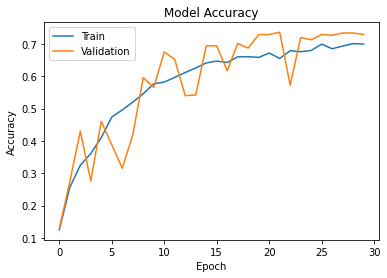

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)  

15/15 - 0s - loss: 0.8297 - accuracy: 0.7432 - 180ms/epoch - 12ms/step


In [18]:
# Output probabilities
y_pred=model3.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


In [19]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

In [20]:
# Plotting the classification report 
from sklearn.metrics import classification_report
cr=classification_report(y_test_arg,y_pred_arg)     
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.63      0.95      0.76        39
           2       0.64      0.72      0.68        29
           3       0.87      0.87      0.87        61
           4       0.63      0.86      0.73        22
           5       0.95      0.42      0.58        48
           6       0.75      0.94      0.84        65
           7       0.75      0.82      0.78        22
           8       0.62      0.87      0.73        52
           9       0.86      0.26      0.40        23
          10       0.90      0.86      0.88        50
          11       0.77      0.79      0.78        38

    accuracy                           0.74       475
   macro avg       0.70      0.70      0.67       475
weighted avg       0.73      0.74      0.71       475



 **Observations**


- With this third model, adding some layers, batach normalization, and drop out, we were just able to improve it slightly from .73 to .74; the model seems to have highly overfit on the training dataset and is performing poorly.

--------------------------------------------------------------------------------

## **Model Building Improvements Using Transfer Learning -Model 4**

In [11]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

# Summary of the whole model
model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 36s 0us/step


In [14]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 5s 0us/step


In [15]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [16]:
# Learning rate reduction
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
# Data Augmentation 

train_datagen = ImageDataGenerator(
                              rotation_range = 20,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode = 'nearest')

In [18]:
# Intializing a sequential model
model4 = Sequential()


model4.add(vgg_model)

model4.add(Flatten())

model4.add(Dense(100, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(12, activation='softmax'))


model4.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model4.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 14,928,528
Trainable params: 213,840
Non-t

In [19]:
# Epochs
epochs = 100
# Batch size
batch_size = 15

history = model4.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=0)

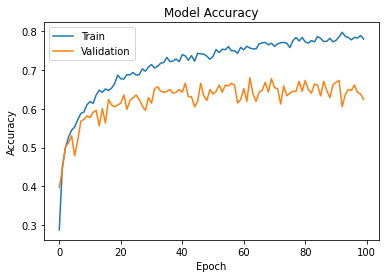

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
accuracy = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2) 

15/15 - 1s - loss: 1.3943 - accuracy: 0.5895 - 750ms/epoch - 50ms/step


In [22]:
# Output probabilities
y_pred=model4.predict(X_test_normalized)

15/15 [==============================] - 0s 21ms/step


In [23]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

In [24]:
# Plotting the classification report 
from sklearn.metrics import classification_report
cr=classification_report(y_test_arg,y_pred_arg)     
print(cr)

              precision    recall  f1-score   support

           0       0.60      0.35      0.44        26
           1       0.44      0.85      0.58        39
           2       0.62      0.45      0.52        29
           3       0.86      0.69      0.76        61
           4       0.48      0.68      0.57        22
           5       0.50      0.48      0.49        48
           6       0.66      0.85      0.74        65
           7       0.65      0.59      0.62        22
           8       0.70      0.54      0.61        52
           9       0.34      0.43      0.38        23
          10       0.72      0.42      0.53        50
          11       0.49      0.47      0.48        38

    accuracy                           0.59       475
   macro avg       0.59      0.57      0.56       475
weighted avg       0.62      0.59      0.59       475



 **Observations**


- In this fourth model we used the pretrained model VGG16 from Imagenet.
-  For this model, only the convolution layers were used from the VGG16, and we increased the epochs to a 100.
-  The results do not improve the previous models, on the contrary they are worst, in the sense that the overall accuracy in the test set diminshes to .59
-  This results will force us to try other architectures and algorithm of the Imagenet series.

## **Model Building Improvements Using Transfer Learning -Model 5**

In [11]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [12]:
# Importing packages and libraries from Keras
from keras.applications.inception_resnet_v2 import preprocess_input

In [13]:
#Only using the convolution layers and discrading the fully connected layers
modelINRSN2 =  tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(75,75,3),
    pooling=None)

219055592/219055592 [==============================] - 2s 0us/step


In [14]:
# Data Augmentation 

train_datagen = ImageDataGenerator(
                              rotation_range = 20,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode = 'nearest')

In [15]:
# Intializing a sequential model
model5 = Sequential()


model5.add(modelINRSN2)

model5.add(Flatten())

model5.add(Dense(100, activation='relu'))
model5.add(Dense(64, activation='relu'))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(12, activation='softmax'))


model5.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model5.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 100)               153700    
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                        

In [16]:
# Epochs
epochs = 100
# Batch size
batch_size = 20

history = model5.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=0)

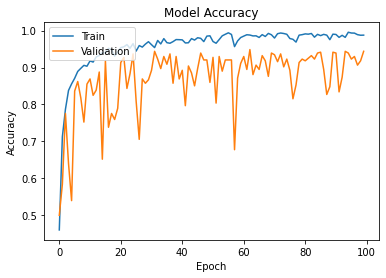

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
accuracy = model5.evaluate(X_test_normalized, y_test_encoded, verbose=2) 

15/15 - 1s - loss: 0.3317 - accuracy: 0.8989 - 1s/epoch - 81ms/step


In [20]:
# Output probabilities
y_pred=model5.predict(X_test_normalized)

15/15 [==============================] - 4s 43ms/step


In [21]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

In [22]:
# Plotting the classification report 
from sklearn.metrics import classification_report
cr=classification_report(y_test_arg,y_pred_arg)     
print(cr)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68        26
           1       1.00      0.95      0.97        39
           2       0.91      1.00      0.95        29
           3       0.98      0.90      0.94        61
           4       1.00      0.86      0.93        22
           5       0.98      1.00      0.99        48
           6       0.90      0.66      0.76        65
           7       0.85      1.00      0.92        22
           8       0.94      0.92      0.93        52
           9       0.95      0.78      0.86        23
          10       0.98      0.94      0.96        50
          11       0.90      0.92      0.91        38

    accuracy                           0.90       475
   macro avg       0.91      0.91      0.90       475
weighted avg       0.92      0.90      0.90       475



 **Observations**


-  In this fourth model we used the pretrained model InceptionResNetV2 from Imagenet.
-  For this model, only the convolution layers were used and used the prevoius model (model 4) for the fully connected layers.
-  The results do improve all the previous models, yielding a overall accuracy of .90, which is a great improvement from the previous models.
-  Still, class 0 is not very well classified and still presents some room for improvement.